In [9]:



import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
import time

## Data quality check / cleaning / preparation 


### Data quality check



y1950 = pd.read_csv('1950.xls')
y1960 = pd.read_csv('1960.xls')
y1970 = pd.read_csv('1970.xls')
y1980 = pd.read_csv('1980.xls')
y1990 = pd.read_csv('1990.xls')
y2000 = pd.read_csv('2000.xls')
y2010 = pd.read_csv('2010.xls')
all_data = pd.concat([y1950,y1960,y1970,y1980,y1990,y2000,y2010])

from sklearn.model_selection import train_test_split
X = all_data.drop('pop', axis=1)
y = all_data['pop']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

## Exploratory data analysis

### Histogram of Popularity Values

#histogram/dist of song popularity values
sns.displot(df['pop'], bins=30)
plt.show()

### Numerical variables against song popularity


#visualizations of all numerical variables (including non-audial features) agaisnt song popularity
predictors = all_data.corr().columns
fig, axes = plt.subplots(4,3,figsize=(20,20))
p = 0
for i in range(4):
    for j in range(3):
        
        if p >= 12:
            break
        predictor = predictors[p]
        
        sns.scatterplot(ax=axes[i,j], x=predictor,y='pop',data=all_data)
        p+=1
plt.show()

## Developing the model




from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = train[['dB', 'dnce', 'nrgy', 'acous', 'dur', 'val', 'spch', 'live']]

X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)



# initial model
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+val', data=train).fit()
print(model.summary())
#test MAE
pred_pop = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print("Test MAE is", mae)
#train MAE
mae_train = (np.abs(train['pop'] - pred_pop)).mean()
print("Train MAE is",mae_train)

#model with **2 transformation on duration
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+I(dur**2)', data=train).fit()
print(model.summary())
#test MAE
pred_pop = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print("Test MAE is", mae)
#train MAE
mae_train = (np.abs(train['pop'] - pred_pop)).mean()
print("Train MAE is",mae_train)

#model with log transformation on duration
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+I(np.log(dur))', data=train).fit()
print(model.summary())
#test MAE
pred_pop = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print("Test MAE is", mae)
#train MAE
mae_train = (np.abs(train['pop'] - pred_pop)).mean()
print("Train MAE is",mae_train)

# model with sqrt tranformation on dur
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+I(np.sqrt(dur))', data=train).fit()
print(model.summary())
#test MAE
pred_pop = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print("Test MAE is", mae)
#train MAE
mae_train = (np.abs(train['pop'] - pred_pop)).mean()
print("Train MAE is",mae_train)



### Code fitting the final model

model_best = smf.ols(formula='pop~acous+dB+dur+nrgy*dnce+val+I(np.log(dur))', data=train).fit()
print(model_best.summary())
#test MAE
pred_pop = model_best.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print("Test MAE is", mae)
#train MAE
mae_train = (np.abs(train['pop'] - pred_pop)).mean()
print("Train MAE is",mae_train)


## Conclusions and Recommendations to stakeholder(s)


FileNotFoundError: [Errno 2] No such file or directory: '1950.xls'

In [10]:
#outliers
sns.scatterplot(x=model_best.fittedvalues, y=model_best.resid, color='orange')
sns.lineplot(x=[pred_pop.min(),pred_pop.max()], y=[0,0],color='blue')
plt.xlabel('Predicted popularity')
plt.ylabel('Residual')
plt.show()

NameError: name 'model_best' is not defined

In [3]:
out = model_best.outlier_test()
# returns a df w the first col as studentized residuals
# res plot, this time w studentized residuals
sns.scatterplot(x=model_best.fittedvalues, y = out.student_resid, color='orange')
sns.lineplot(x = [model_best.fittedvalues.min(),model_best.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Predicted popularity')
plt.ylabel('Studentized residuals')
plt.show()

NameError: name 'model_best' is not defined

In [4]:
print(np.sum(np.abs(out.student_resid) > 3)) # 3 outliers

NameError: name 'np' is not defined

In [5]:
# leverage calculations
influence = model_best.get_influence()
leverage = influence.hat_matrix_diag
cutoff = 4*(model_best.df_model+1)/model_best.nobs
print(np.sum(leverage>cutoff)) #6 high leverage points

NameError: name 'model_best' is not defined

In [6]:
#Dropping influential points from data
train_filtered = train.drop(np.intersect1d(np.where(np.abs(out.student_resid)>3)[0],
                                           (np.where(leverage>cutoff)[0])))
train_filtered.shape[0]-train.shape[0]
#no influential points

NameError: name 'train' is not defined

# forward stepwise

In [24]:
#Creating a dataframe with all the predictors
X = train[['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur','acous', 'spch']]
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train[['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur','acous', 'spch']]
Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('pop~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

SyntaxError: invalid syntax (597491948.py, line 5)

In [25]:
models_best = forward_selection()

NameError: name 'X' is not defined

In [26]:
best_sub_plots()

NameError: name 'best_sub_plots' is not defined

In [27]:
best_fwd_reg_model = models_best['model'][6]
best_fwd_reg_model.summary()

NameError: name 'models_best' is not defined

In [11]:
#lasso
X = train[['acous','dB','dur','nrgy','dnce','val']]
X['nrgy*dnce'] = X['nrgy']*X['dnce']
X['I(np.log(dur))'] = np.log(X['dur'])

# let us develop a lasso model to predict pop based on the predictors in model_best

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

NameError: name 'train' is not defined

In [12]:
y = train['pop']
alphas = 10**np.linspace(10,-2,100)*0.1
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

NameError: name 'train' is not defined

NameError: name 'coefs' is not defined

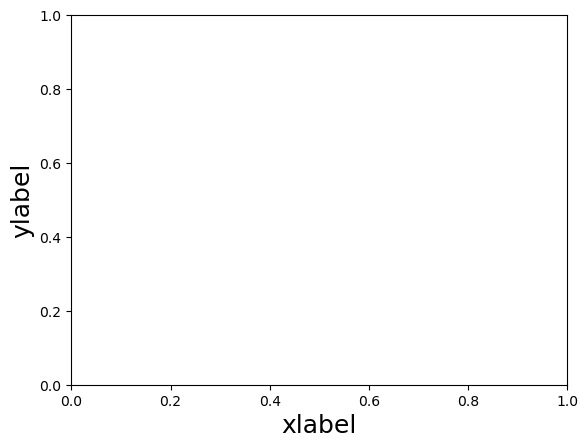

In [17]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(X);
plt.plot([lassocv.alpha_,lassocv.alpha_],[-15,15],':')
plt.legend(X);

In [14]:
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

NameError: name 'LassoCV' is not defined

In [15]:
Xtest = test[['acous','dB','dur','nrgy','dnce','val']]
Xtest['nrgy*dnce'] = Xtest['nrgy']*Xtest['dnce']
Xtest['I(np.log(dur))'] = np.log(Xtest['dur'])

Xtest_std = scaler.transform(Xtest)

NameError: name 'test' is not defined

In [16]:
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

NameError: name 'Lasso' is not defined

In [ ]:
best_coeffs = lasso.coef_